## Exploratory Data Analysis - Anti Microbial Peptides

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import Bio
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from scipy.stats import pearsonr
import os

import sys  
sys.path.insert(0, '../scripts')

import eda_utils as eda

%matplotlib inline

Allow multiple outputs from each cell.

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Load in all data

In [3]:
df_full = pd.read_csv("../data/amp/all_data.csv")
print(f"Full dataset shape: {df_full.shape}")
df_full.head()

Full dataset shape: (4042, 3)


,PDBs_code,SequenceID,label
0,AP02484,GMASKAGSVLGKITKIALGAL,1
1,AP02630,NIGLFTSTCFSSQCFSSKCFTDTCFSSNCFTGRHQCGYTHGSC,1
2,AP01427,GAIKDALKGAAKTVAVELLKKAQCKLEKTC,1
3,AP02983,FFGRLKAVFRGARQGWKEHRY,1
4,AP01815,DFGCARGMIFVCMRRCARMYPGSTGYCQGFRCMCDTMIPIRRPPFIMG,1


Split into train and test datasets for EDA.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df_full[["PDBs_code", "SequenceID"]], \
    df_full["label"], test_size=0.2, random_state=42, stratify=df_full["label"])

df_train = X_train.copy()
df_train["label"] = y_train

df_test = X_test.copy()
df_test["label"] = y_test

print(f"Train dataset shape: {df_train.shape}")
print(f"Test dataset shape: {df_test.shape}")

train_per = round(100*(df_train.shape[0]/(df_train.shape[0]+df_test.shape[0])))
print(f"Train-test split: {train_per}% Train, {100-train_per}% Test")

Train dataset shape: (3233, 3)
Test dataset shape: (809, 3)
Train-test split: 80% Train, 20% Test


Take a look at the format of the data.

In [5]:
df_train.head()
df_train.dtypes
print(f"Unique values of label: {df_train.label.unique()}")

,PDBs_code,SequenceID,label
2049,UniRef50_Q6ZRV2,SGSYSFMWSFEKIHRSLAHVFQGEL,0
1041,AP02875,LKRVWKRVFKLLKRYWRQLKKPVR,1
1159,AP01644,GAFGNFLKGVAKKAGLKILSIAQCKLSGTC,1
2007,AP02453,MDSFQKIEKIGEGTYGVVYKAKDKVSGRLVALKKIRLENESEGVPSTA,1
3822,UniRef50_Q9BRR0,PESQGLLKVEDVALTLTPEWTQQDSSQGNL,0


PDBs_code     object
SequenceID    object
label          int64
dtype: object

Unique values of label: [0 1]


### Checking for Duplicates

Making sure there are no duplicate proteins.

In [6]:
df_train["SequenceID"].duplicated().sum()
df_test["SequenceID"].duplicated().sum()

0

0

Check for distribution of classes to identify potential imbalances.

In [7]:
df_train.label.value_counts()
df_test.label.value_counts()
print("Both train and test datasets are almost perfectly balanced between the positive and negative class")

1    1617
0    1616
Name: label, dtype: int64

0    405
1    404
Name: label, dtype: int64

Both train and test datasets are almost perfectly balanced between the positive and negative class


Check if any leading or trailing white spaces present in sequences

In [8]:
len_train = df_train.SequenceID.apply(len)
len_train_2 = df_train.SequenceID.str.strip().apply(len)

len_test = df_test.SequenceID.apply(len)
len_test_2 = df_test.SequenceID.str.strip().apply(len)

In [9]:
np.where(len_train != len_train_2)
np.where(len_test != len_test_2)

(array([], dtype=int64),)

(array([], dtype=int64),)

No white spaces present in sequences

### Sequence Sizes

Visualizing the distribution of the lengths of sequences in each dataset.

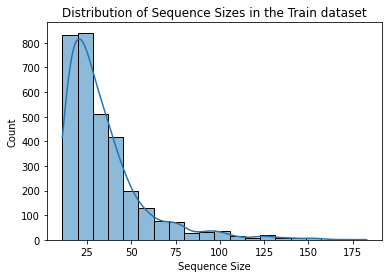

In [10]:
sns.histplot(df_train["SequenceID"].str.len(), bins=20, kde=True);
plt.xlabel("Sequence Size");
plt.title('Distribution of Sequence Sizes in the Train dataset');

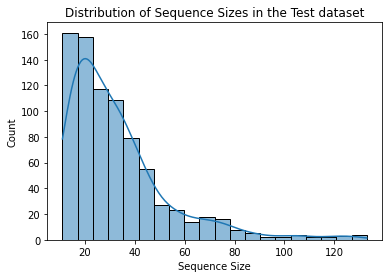

In [11]:
sns.histplot(df_test["SequenceID"].str.len(), bins=20, kde=True);
plt.xlabel("Sequence Size");
plt.title('Distribution of Sequence Sizes in the Test dataset');

In [12]:
train_seq_sizes = df_train["SequenceID"].str.len()
test_seq_sizes = df_test["SequenceID"].str.len()

print(f"Train dataset - mean of sequence sizes: {train_seq_sizes.mean()}")
print(f"Test dataset - mean of sequence sizes: {test_seq_sizes.mean()}")

print(f"Train dataset - smallest sequence size: {train_seq_sizes.min()}")
print(f"Test dataset - smallest sequence size: {test_seq_sizes.min()}")

print(f"Train dataset - largest sequence size: {train_seq_sizes.max()}")
print(f"Test dataset - largest sequence size: {test_seq_sizes.max()}")

Train dataset - mean of sequence sizes: 34.250850603154966
Test dataset - mean of sequence sizes: 33.00988875154512
Train dataset - smallest sequence size: 11
Test dataset - smallest sequence size: 11
Train dataset - largest sequence size: 183
Test dataset - largest sequence size: 133


## Feature Engineering - Protein Features

#### Checking set of amino acids present in dataset

In [13]:
amino_acids = set()
for protein in df_train.SequenceID:
    for acid in protein:
        amino_acids.add(acid)

for protein in df_test.SequenceID:
    for acid in protein:
        amino_acids.add(acid)
        
print(amino_acids)
print(len(amino_acids))

{'D', 'C', 'S', 'V', 'L', 'Y', 'M', 'W', 'N', 'X', 'P', 'I', 'T', 'F', 'K', 'E', 'A', 'R', 'G', 'H', 'Q'}
21


This dataset has an extra amino acid symbol besides the 20 natural amino acids. 'X' denotes an unknown amino acid, and we have to decide how to handle this in our feature engineering.

#### Identifying and Counting number of occurrences of X in Train and Test Sets

In [14]:
count = 0
for idx, prot in zip(df_train.index, df_train.SequenceID):
    x_count = prot.count('X')
    if x_count != 0:
        count += x_count
        print(f"{x_count} X's appears at Index {idx}")
    c_count = 0

print(f"Total amount of X's in Train set: {count}")

3 X's appears at Index 3139
Total amount of X's in Train set: 3


In [15]:
df_train.loc[3139].SequenceID

'ITXAAVVLDKXKXYEVDIKKATPKDAMMMPPMRGGR'

In [16]:
count = 0
for idx, prot in zip(df_test.index, df_test.SequenceID):
    x_count = prot.count('X')
    if x_count != 0:
        count += x_count
        print(f"{x_count} X's appears at Index {idx}")
    c_count = 0

print(f"Total amount of X's in Test set: {count}")

1 X's appears at Index 3348
Total amount of X's in Test set: 1


In [17]:
df_test.loc[3348].SequenceID

'EKIKTLVSKXFKEIVLTGVNTAGYLDENNNTFFDLLNNINKLDGDFRVRISSLEPFQINDEIID'

It looks like the X's only occur in 2 sequences, one in the train and test set each.

In [18]:
# Add protein features as columns
df_train = eda.add_protein_features(df_train, "SequenceID")
df_test = eda.add_protein_features(df_test, "SequenceID")

In [28]:
df_train.head()

,PDBs_code,SequenceID,label,amino_acid_count,amino_acid_percent,molecular_weight,instability_index,flexibility,gravy,aromaticity,isoelectric_point,charge_at_pH,helix_frac,turn_frac,sheet_frac,molar_extinction_coefficient
2049,UniRef50_Q6ZRV2,SGSYSFMWSFEKIHRSLAHVFQGEL,0,"{'A': 1, 'C': 0, 'D': 0, 'E': 2, 'F': 3, 'G': ...","{'A': 4.0, 'C': 0.0, 'D': 0.0, 'E': 8.0, 'F': ...",2944.2804,22.304000,0.981972,-0.156000,0.200000,6.666895,-0.676314,0.360000,0.280000,0.240000,6990.0
1041,AP02875,LKRVWKRVFKLLKRYWRQLKKPVR,1,"{'A': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 1, 'G': ...","{'A': 0.0, 'C': 0.0, 'D': 0.0, 'E': 0.0, 'F': ...",3226.0122,35.366667,0.992210,-0.979167,0.166667,11.999968,10.539788,0.458333,0.041667,0.166667,12490.0
1159,AP01644,GAFGNFLKGVAKKAGLKILSIAQCKLSGTC,1,"{'A': 4, 'C': 2, 'D': 0, 'E': 0, 'F': 2, 'G': ...","{'A': 13.333333333333334, 'C': 6.6666666666666...",3024.6452,-14.076667,1.000375,0.513333,0.066667,9.904294,4.495918,0.300000,0.266667,0.266667,62.5
2007,AP02453,MDSFQKIEKIGEGTYGVVYKAKDKVSGRLVALKKIRLENESEGVPSTA,1,"{'A': 3, 'C': 0, 'D': 2, 'E': 5, 'F': 1, 'G': ...","{'A': 6.25, 'C': 0.0, 'D': 4.166666666666666, ...",5271.0086,21.716667,1.015507,-0.470833,0.062500,9.099600,1.268785,0.291667,0.229167,0.250000,2980.0
3822,UniRef50_Q9BRR0,PESQGLLKVEDVALTLTPEWTQQDSSQGNL,0,"{'A': 1, 'C': 0, 'D': 2, 'E': 3, 'F': 0, 'G': ...","{'A': 3.3333333333333335, 'C': 0.0, 'D': 6.666...",3284.5382,51.590000,1.007158,-0.636667,0.033333,4.050028,-4.096922,0.266667,0.266667,0.300000,5500.0


In [29]:
df_train.dtypes

PDBs_code                        object
SequenceID                       object
label                             int64
amino_acid_count                 object
amino_acid_percent               object
molecular_weight                float64
instability_index               float64
flexibility                     float64
gravy                           float64
aromaticity                     float64
isoelectric_point               float64
charge_at_pH                    float64
helix_frac                      float64
turn_frac                       float64
sheet_frac                      float64
molar_extinction_coefficient    float64
dtype: object

### Amino Acid Frequencies/Composition

#### Get average amino acid content of sequences

In [37]:
print(amino_acids)

{'D', 'C', 'S', 'V', 'L', 'Y', 'M', 'W', 'N', 'X', 'P', 'I', 'T', 'F', 'K', 'E', 'A', 'R', 'G', 'H', 'Q'}


In [38]:
amp_avg_acids = eda.get_avg_amino_acid_count(df_train[df_train.label==1], amino_acids)
non_amp_avg_acids = eda.get_avg_amino_acid_count(df_train[df_train.label==0], amino_acids)

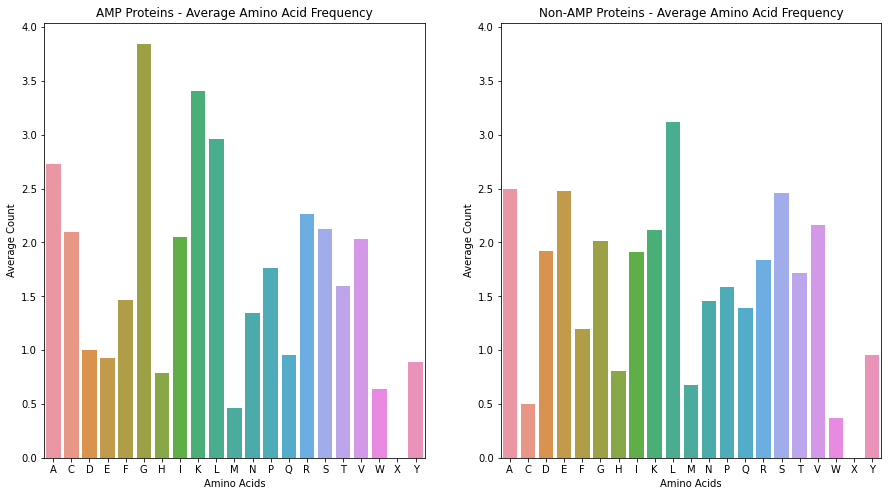

In [39]:
plt.figure(figsize=(15,8))

ax1 = plt.subplot(121)
sns.barplot(x = sorted(amp_avg_acids.keys()), 
            y = [amp_avg_acids.get(key) for key in sorted(amp_avg_acids.keys())]).set(
                title='AMP Proteins - Average Amino Acid Frequency');
ax1.set(xlabel='Amino Acids', ylabel='Average Count');

ax2 = plt.subplot(122, sharey=ax1)
sns.barplot(x = sorted(non_amp_avg_acids.keys()), 
            y = [non_amp_avg_acids.get(key) for key in sorted(non_amp_avg_acids.keys())]).set(
                title='Non-AMP Proteins - Average Amino Acid Frequency');
ax2.set(xlabel='Amino Acids', ylabel='Average Count');

In [40]:
pearsonr([acp_avg_acids.get(key) for key in sorted(acp_avg_acids.keys())],
            [non_acp_avg_acids.get(key) for key in sorted(non_acp_avg_acids.keys())])[0]

0.6669663785245947

As seen in both the barplots of and correlation between the amino acid average counts of acp and non-acp proteins, there is significant correlation between these two, but not so significant as to not have any predictive power. This could potentially be a valuable feature for an AMP classifier. 

However, it should be noted that the proteins chosen for this dataset may not be indicative of general trends in amino acid frequency, so we have to take care to be aware of this assumption if using this feature in our models.

#### Get average percentage of amino acids for each sequence

In [51]:
# Get average percentage of frequency of each amino acid over all ACP and non-ACP sequences
amp_avg_acids_percent = eda.get_avg_amino_acid_percent(df_train[df_train.label==1], amino_acids)
non_amp_avg_acids_percent = eda.get_avg_amino_acid_percent(df_train[df_train.label==0], amino_acids)

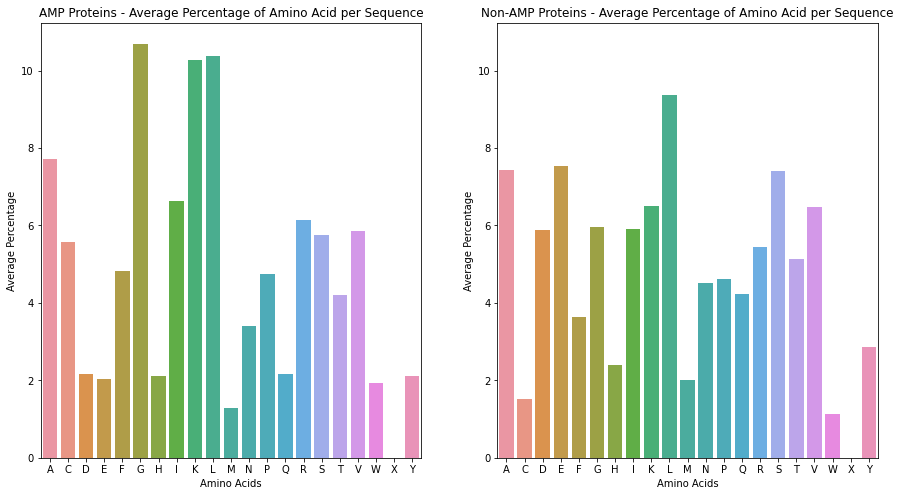

In [52]:
plt.figure(figsize=(15,8))
ax1 = plt.subplot(121)
sns.barplot(x = sorted(amp_avg_acids_percent.keys()), 
            y = [amp_avg_acids_percent.get(key) for key in sorted(amp_avg_acids_percent.keys())]).set(
                title='AMP Proteins - Average Percentage of Amino Acid per Sequence');
ax1.set(xlabel='Amino Acids', ylabel='Average Percentage');
ax2 = plt.subplot(122, sharey=ax1)
sns.barplot(x = sorted(non_amp_avg_acids_percent.keys()), 
            y = [non_amp_avg_acids_percent.get(key) for key in sorted(non_amp_avg_acids_percent.keys())]).set(
                title='Non-AMP Proteins - Average Percentage of Amino Acid per Sequence');
ax2.set(xlabel='Amino Acids', ylabel='Average Percentage');


In [53]:
pearsonr([amp_avg_acids_percent.get(key) for key in sorted(amp_avg_acids_percent.keys())],
            [non_amp_avg_acids_percent.get(key) for key in sorted(non_amp_avg_acids_percent.keys())])[0]

0.6610699272656704

Just like with the barplots and correlation for the amino_acid_count feature, there is significant correlation between amino_acid_avg percentages, but not so significant as to not have any predictive power. This could potentially be a valuable feature for an AMP classifier, although it likely is multicollinear with amino_acid_count, so one of these would probably have to kept and the other removed.

### All other Protein Features

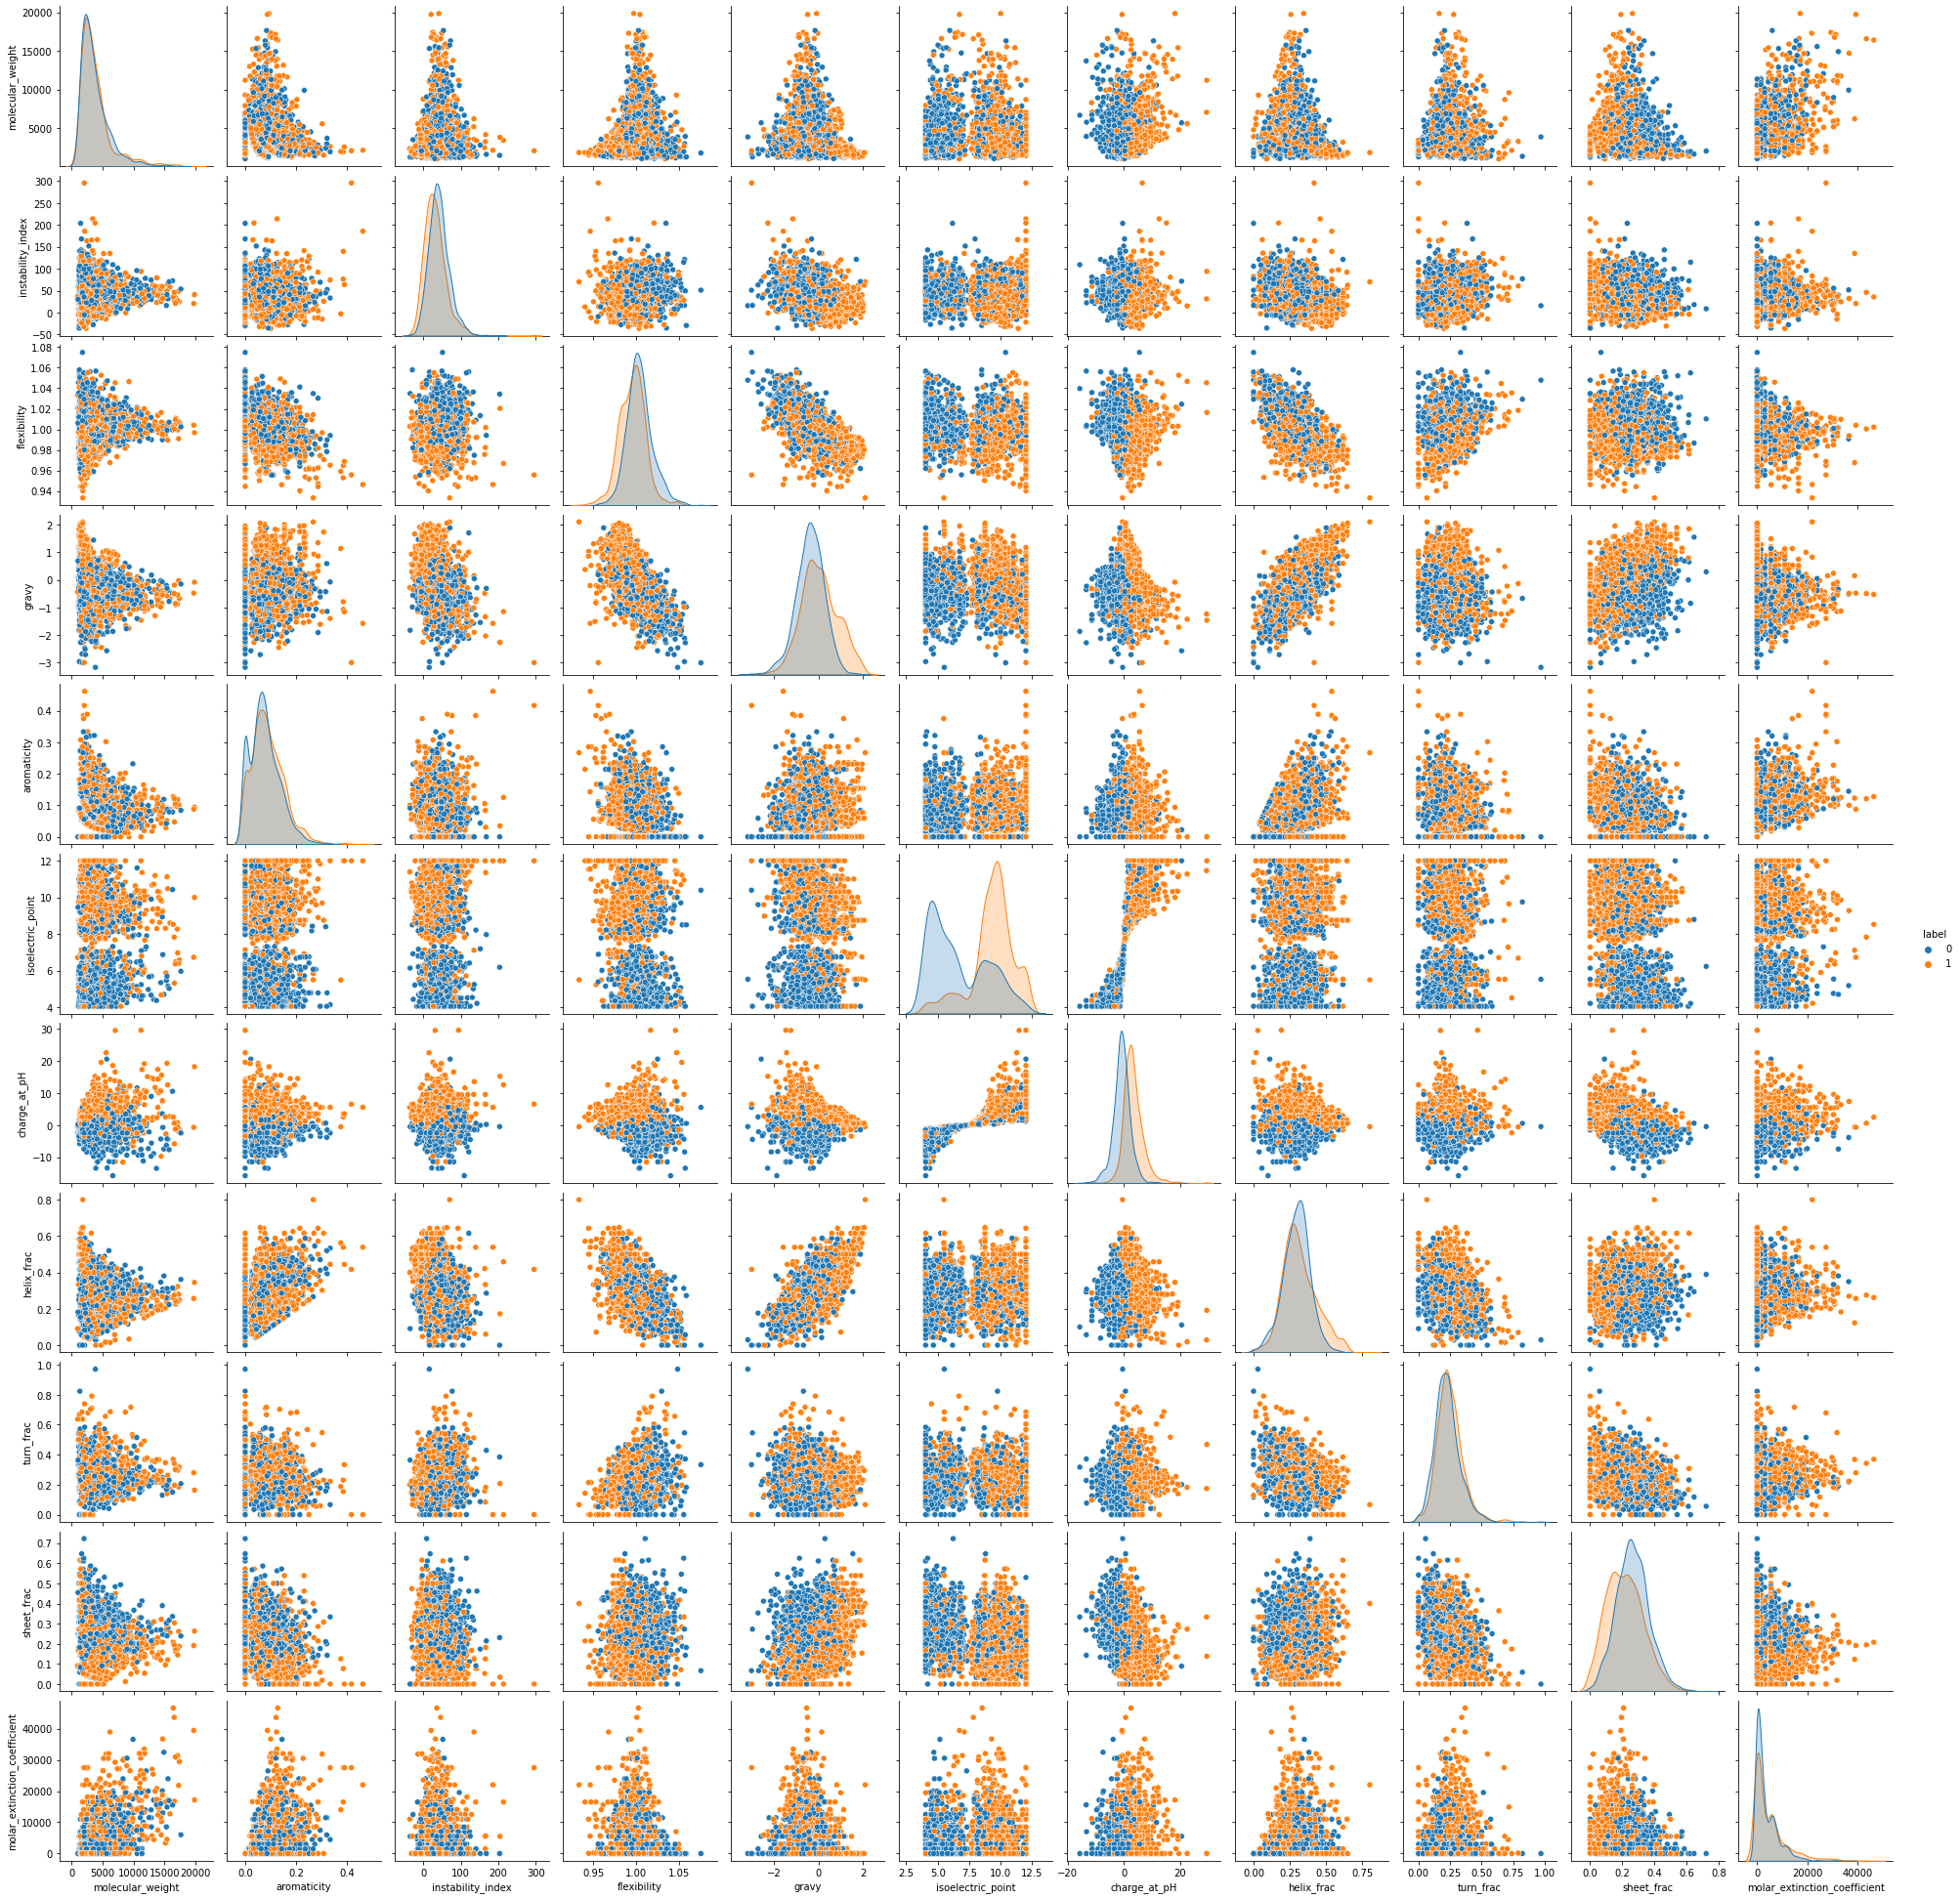

In [46]:
prot_features=["molecular_weight", "aromaticity", "instability_index", "flexibility", "gravy", 
               "isoelectric_point", "charge_at_pH", "helix_frac", "turn_frac", "sheet_frac",
               "molar_extinction_coefficient"]
sns.pairplot(data=df_train, x_vars=prot_features, hue="label")

There seems to be a significant amount of separation between AMPs and non-AMPs with regards to these features, although the two groups are not fully separated by any of these features. It is possible however that a classifier that uses all of these features might perform well at the AMP classification task.

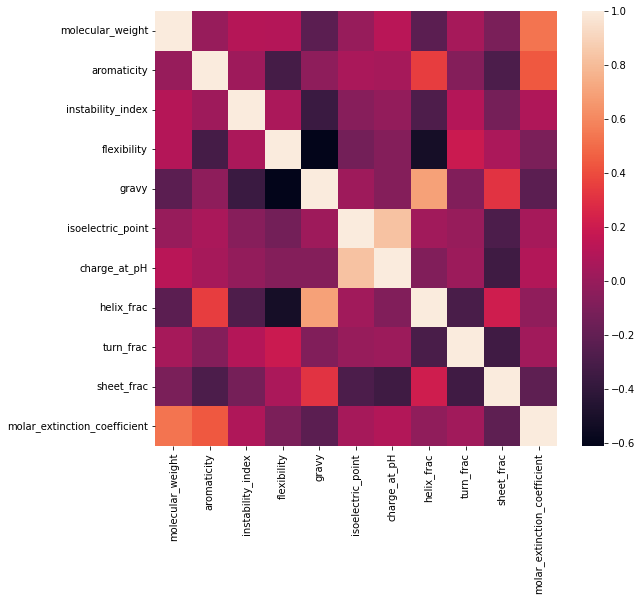

In [47]:
plt.figure(figsize=(9,8))
sns.heatmap(data=df_train[prot_features].corr());

It looks like the most highly correlated features are `charge_at_pH` and `isoelectric_point`. This makes sense, as both refer to a pH value, the first being the charge of the protein at the average human body pH (7.4), and the second as the pH at which no net migration takes place in an electric field.

The `helix_frac` and `gravy` are also significantly correlated, although to a lesser degree than the pH features. 

Since all these features are highly correlated, they are all potential candidates for removal during modelling in order to avoid multicollinearity, after checking the variance inflation factor to quantify the severity of multicollinearity. 

In [54]:
df_full_expanded = eda.add_protein_features(df_full, "SequenceID")

In [55]:
df_full_expanded.to_csv("../data/amp/all_data_expanded.csv", index=False)

## Alignment

In [57]:
sequences = df_full_expanded.copy()
sequences.drop(df_full_expanded.columns.difference(["SequenceID", "label"]), axis=1, inplace=True)
sequences.head()

,SequenceID,label
0,GMASKAGSVLGKITKIALGAL,1
1,NIGLFTSTCFSSQCFSSKCFTDTCFSSNCFTGRHQCGYTHGSC,1
2,GAIKDALKGAAKTVAVELLKKAQCKLEKTC,1
3,FFGRLKAVFRGARQGWKEHRY,1
4,DFGCARGMIFVCMRRCARMYPGSTGYCQGFRCMCDTMIPIRRPPFIMG,1


In [59]:
# Demonstrate pairwise alignment 
for idx, prot_1 in enumerate(sequences.SequenceID[:3]):
    sim_seq = None
    max_score = 0
    alignment = None
    for prot_2 in sequences.SequenceID.drop(idx):
        alignments = pairwise2.align.globalxx(prot_1, prot_2)
        score = int(format_alignment(*alignments[0]).split("Score=")[1].rstrip())
        if score > max_score:
            max_score = score
            sim_seq = prot_2
            alignment = format_alignment(*alignments[0])
    print(max_score, sim_seq)
    print(alignment)

20 MGYGDIMKVDTSGASMKTAGQDRLTYAGVAASNTMAQTDLGRMNNYKAIIQRVGGKKDVDPAIIAGIISRESRAGNVLVNGWGDNGNAWGLMQVDKRYHTPQGGWNSEEHLSQGTDIISFIKQVQGKFPSWTAEQQLKGGIAAYNIGLGGVQTYERMDVGTTGDDYSSDVVARAQWYKSQGGF
-G----M------AS-K-AG-----------S--------------------V------------------------L--G--------------K--------------------I--------------T-----K--IA-----LG----------------------AL-----------
 |    |      || | ||           |                    |                        |  |              |                    |              |     |  ||     ||                      |            
MGYGDIMKVDTSGASMKTAGQDRLTYAGVAASNTMAQTDLGRMNNYKAIIQRVGGKKDVDPAIIAGIISRESRAGNVLVNGWGDNGNAWGLMQVDKRYHTPQGGWNSEEHLSQGTDIISFIKQVQGKFPSWTAEQQLKGGIAAYNIGLGGVQTYERMDVGTTGDDYSSDVVA-RAQWYKSQGGF
  Score=20

27 MLVNFILRCGLLLVTLSLAIAKHKQSSFTKSCYPRGTLSQAVDALYIKAAWLKATIPEDRIKNIRLLKKKTKKQFMKNCQFQEQLLSFFMEDVFGQLQLQGCKKIRFVEDFHSLRQKLSHCISCASSAREMKSITRMKRIFYRIGNKGIYKAISELDILLSWIKKLLESSQ
---N-I---GLF---T-STCF--------SSQCF--S-------S--------KCF------T---D----

### Investigating cross-similarity scores

In [61]:
cross_df = pd.DataFrame(index=df_full_expanded.SequenceID, columns=df_full_expanded.SequenceID)
cross_df.head()

SequenceID,GMASKAGSVLGKITKIALGAL,NIGLFTSTCFSSQCFSSKCFTDTCFSSNCFTGRHQCGYTHGSC,GAIKDALKGAAKTVAVELLKKAQCKLEKTC,FFGRLKAVFRGARQGWKEHRY,DFGCARGMIFVCMRRCARMYPGSTGYCQGFRCMCDTMIPIRRPPFIMG,GRRKRKWLRRIGKGVKIIGGAALDHL,LLMRKLIKGYGYLFGKGKRKKR,LIDHLGAPRWAVDTILGAIAVGNLASWVLALVPGPGWAVKAGLATAAAIVKHQGKAAAAAW,ILPLLLGKVVCAITKKC,FKKKKRNIGTFVFFAIALFCTVMFAYLLLTNQYVPIDYNVPRYA,...,TDSAVAKTIEESISKNYPK,FDQNMNDSCEDALANKTRPRNREEVIFDNLMLN,HELTHNVHGEHDSSFWELFRQ,NEDLRTFQLSKKFVKEYESKYYSLPRLKILEIKANNKRQRTFNRQRHHQKLVLRPSLFC,VFDAYRPIAVQQFMVDHTFAEIVARDGLQGQVLTPEQKENIYHQVYQIWAVPNNNPL,SSGNVNEVPKQNAKHPMDSCQNLEQSAGTTSAEKEAIRALESQSSGTSQASLAKHKSETNTSIQSSTQETAQAPTVYEELGSEAER,ESCNFAVFWKLVKGAYKPTTNPNEPFKVPGEVPKMIKPMVGFEDAVKHYACRVISVTFQKIEKKMLSRLLGGASDKEVTALAQSFG,VAALNDCIYSVGGWNETQDALHTVEKYSFEEEKWVEVASMKVPRAGMCVVAVN,PHTHTQKEVITSSVD,LTLSEFLKLDLEHTKIKMQKQMNLH
SequenceID,,,,,,,,,,,,,,,,,,,,,
GMASKAGSVLGKITKIALGAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIGLFTSTCFSSQCFSSKCFTDTCFSSNCFTGRHQCGYTHGSC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GAIKDALKGAAKTVAVELLKKAQCKLEKTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FFGRLKAVFRGARQGWKEHRY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DFGCARGMIFVCMRRCARMYPGSTGYCQGFRCMCDTMIPIRRPPFIMG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
%%time
# Get cross similarity scores of each pair of sequences
cross_df = cross_df.apply(lambda x: pd.DataFrame(x).apply(lambda y: pairwise2.align.globalxx(x.name, y.name, score_only=True), axis=1))

CPU times: user 12min 6s, sys: 385 ms, total: 12min 6s
Wall time: 12min 6s


In [63]:
cross_df

SequenceID,GMASKAGSVLGKITKIALGAL,NIGLFTSTCFSSQCFSSKCFTDTCFSSNCFTGRHQCGYTHGSC,GAIKDALKGAAKTVAVELLKKAQCKLEKTC,FFGRLKAVFRGARQGWKEHRY,DFGCARGMIFVCMRRCARMYPGSTGYCQGFRCMCDTMIPIRRPPFIMG,GRRKRKWLRRIGKGVKIIGGAALDHL,LLMRKLIKGYGYLFGKGKRKKR,LIDHLGAPRWAVDTILGAIAVGNLASWVLALVPGPGWAVKAGLATAAAIVKHQGKAAAAAW,ILPLLLGKVVCAITKKC,FKKKKRNIGTFVFFAIALFCTVMFAYLLLTNQYVPIDYNVPRYA,...,TDSAVAKTIEESISKNYPK,FDQNMNDSCEDALANKTRPRNREEVIFDNLMLN,HELTHNVHGEHDSSFWELFRQ,NEDLRTFQLSKKFVKEYESKYYSLPRLKILEIKANNKRQRTFNRQRHHQKLVLRPSLFC,VFDAYRPIAVQQFMVDHTFAEIVARDGLQGQVLTPEQKENIYHQVYQIWAVPNNNPL,SSGNVNEVPKQNAKHPMDSCQNLEQSAGTTSAEKEAIRALESQSSGTSQASLAKHKSETNTSIQSSTQETAQAPTVYEELGSEAER,ESCNFAVFWKLVKGAYKPTTNPNEPFKVPGEVPKMIKPMVGFEDAVKHYACRVISVTFQKIEKKMLSRLLGGASDKEVTALAQSFG,VAALNDCIYSVGGWNETQDALHTVEKYSFEEEKWVEVASMKVPRAGMCVVAVN,PHTHTQKEVITSSVD,LTLSEFLKLDLEHTKIKMQKQMNLH
SequenceID,,,,,,,,,,,,,,,,,,,,,
GMASKAGSVLGKITKIALGAL,21.0,7.0,12.0,7.0,9.0,10.0,7.0,13.0,6.0,9.0,...,6.0,9.0,4.0,10.0,11.0,16.0,15.0,10.0,4.0,7.0
NIGLFTSTCFSSQCFSSKCFTDTCFSSNCFTGRHQCGYTHGSC,7.0,43.0,8.0,9.0,12.0,6.0,7.0,10.0,6.0,13.0,...,8.0,8.0,8.0,17.0,11.0,19.0,15.0,12.0,7.0,9.0
GAIKDALKGAAKTVAVELLKKAQCKLEKTC,12.0,8.0,30.0,9.0,9.0,9.0,9.0,16.0,10.0,12.0,...,8.0,9.0,6.0,15.0,11.0,17.0,18.0,13.0,5.0,10.0
FFGRLKAVFRGARQGWKEHRY,7.0,9.0,9.0,21.0,10.0,8.0,8.0,11.0,5.0,9.0,...,6.0,6.0,6.0,12.0,13.0,11.0,13.0,8.0,3.0,6.0
DFGCARGMIFVCMRRCARMYPGSTGYCQGFRCMCDTMIPIRRPPFIMG,9.0,12.0,9.0,10.0,48.0,10.0,8.0,15.0,6.0,14.0,...,8.0,11.0,5.0,14.0,16.0,14.0,18.0,13.0,4.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SSGNVNEVPKQNAKHPMDSCQNLEQSAGTTSAEKEAIRALESQSSGTSQASLAKHKSETNTSIQSSTQETAQAPTVYEELGSEAER,16.0,19.0,17.0,11.0,14.0,12.0,9.0,22.0,9.0,19.0,...,12.0,16.0,11.0,22.0,24.0,86.0,28.0,20.0,11.0,13.0
ESCNFAVFWKLVKGAYKPTTNPNEPFKVPGEVPKMIKPMVGFEDAVKHYACRVISVTFQKIEKKMLSRLLGGASDKEVTALAQSFG,15.0,15.0,18.0,13.0,18.0,15.0,14.0,23.0,11.0,19.0,...,12.0,17.0,14.0,24.0,21.0,28.0,86.0,22.0,11.0,14.0
VAALNDCIYSVGGWNETQDALHTVEKYSFEEEKWVEVASMKVPRAGMCVVAVN,10.0,12.0,13.0,8.0,13.0,8.0,9.0,18.0,8.0,15.0,...,10.0,13.0,11.0,17.0,19.0,20.0,22.0,53.0,8.0,13.0


Note that the diagonal elements are equal to the length of that sequence.

In [64]:
# Verifying that the cross-similarity matrix is symmetric
cross_np = cross_df.values
np.all(cross_np == cross_np.T)

True

### Normalized cross-similarity matrices

In [65]:
norm_cross_df = cross_df/np.diag(cross_df)

In [66]:
norm_cross_df.head()

SequenceID,GMASKAGSVLGKITKIALGAL,NIGLFTSTCFSSQCFSSKCFTDTCFSSNCFTGRHQCGYTHGSC,GAIKDALKGAAKTVAVELLKKAQCKLEKTC,FFGRLKAVFRGARQGWKEHRY,DFGCARGMIFVCMRRCARMYPGSTGYCQGFRCMCDTMIPIRRPPFIMG,GRRKRKWLRRIGKGVKIIGGAALDHL,LLMRKLIKGYGYLFGKGKRKKR,LIDHLGAPRWAVDTILGAIAVGNLASWVLALVPGPGWAVKAGLATAAAIVKHQGKAAAAAW,ILPLLLGKVVCAITKKC,FKKKKRNIGTFVFFAIALFCTVMFAYLLLTNQYVPIDYNVPRYA,...,TDSAVAKTIEESISKNYPK,FDQNMNDSCEDALANKTRPRNREEVIFDNLMLN,HELTHNVHGEHDSSFWELFRQ,NEDLRTFQLSKKFVKEYESKYYSLPRLKILEIKANNKRQRTFNRQRHHQKLVLRPSLFC,VFDAYRPIAVQQFMVDHTFAEIVARDGLQGQVLTPEQKENIYHQVYQIWAVPNNNPL,SSGNVNEVPKQNAKHPMDSCQNLEQSAGTTSAEKEAIRALESQSSGTSQASLAKHKSETNTSIQSSTQETAQAPTVYEELGSEAER,ESCNFAVFWKLVKGAYKPTTNPNEPFKVPGEVPKMIKPMVGFEDAVKHYACRVISVTFQKIEKKMLSRLLGGASDKEVTALAQSFG,VAALNDCIYSVGGWNETQDALHTVEKYSFEEEKWVEVASMKVPRAGMCVVAVN,PHTHTQKEVITSSVD,LTLSEFLKLDLEHTKIKMQKQMNLH
SequenceID,,,,,,,,,,,,,,,,,,,,,
GMASKAGSVLGKITKIALGAL,1.000000,0.162791,0.400000,0.333333,0.187500,0.384615,0.318182,0.213115,0.352941,0.204545,...,0.315789,0.272727,0.190476,0.169492,0.192982,0.186047,0.174419,0.188679,0.266667,0.28
NIGLFTSTCFSSQCFSSKCFTDTCFSSNCFTGRHQCGYTHGSC,0.333333,1.000000,0.266667,0.428571,0.250000,0.230769,0.318182,0.163934,0.352941,0.295455,...,0.421053,0.242424,0.380952,0.288136,0.192982,0.220930,0.174419,0.226415,0.466667,0.36
GAIKDALKGAAKTVAVELLKKAQCKLEKTC,0.571429,0.186047,1.000000,0.428571,0.187500,0.346154,0.409091,0.262295,0.588235,0.272727,...,0.421053,0.272727,0.285714,0.254237,0.192982,0.197674,0.209302,0.245283,0.333333,0.40
FFGRLKAVFRGARQGWKEHRY,0.333333,0.209302,0.300000,1.000000,0.208333,0.307692,0.363636,0.180328,0.294118,0.204545,...,0.315789,0.181818,0.285714,0.203390,0.228070,0.127907,0.151163,0.150943,0.200000,0.24
DFGCARGMIFVCMRRCARMYPGSTGYCQGFRCMCDTMIPIRRPPFIMG,0.428571,0.279070,0.300000,0.476190,1.000000,0.384615,0.363636,0.245902,0.352941,0.318182,...,0.421053,0.333333,0.238095,0.237288,0.280702,0.162791,0.209302,0.245283,0.266667,0.24


In [72]:
# Verifying normalization performed correctly, diagonals are filled with 1's
assert np.all(np.diag(norm_cross_df) == 1)

In [68]:
# Verifying that normalized matrix is no longer symmetric, due to the different sizes of sequences
assert not (np.all(norm_cross_df != norm_cross_df.T))

Visualizing distribution of normalized simalirity scores

In [69]:
# Removing 1's from cross similarity arrays since they only occur on diagonal
norm_arr = np.delete(norm_cross_df.to_numpy().flatten(), np.where(norm_cross_df.to_numpy().flatten() == 1))

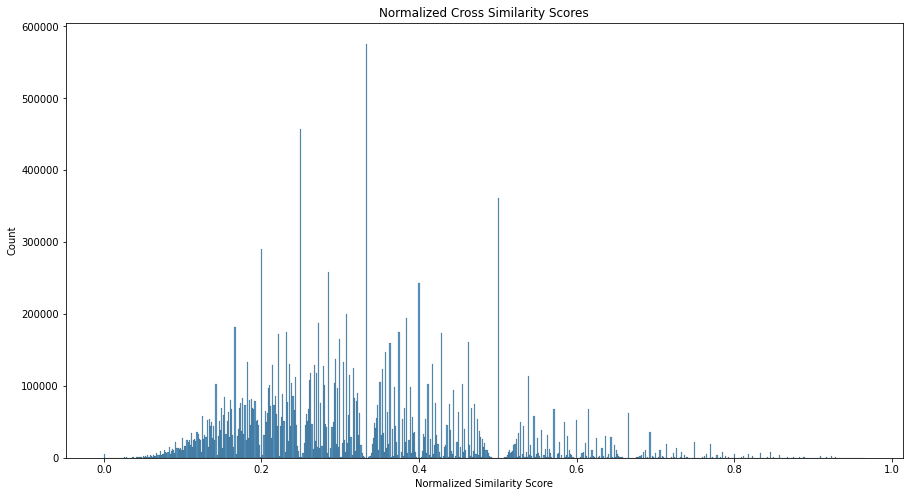

In [70]:
plt.figure(figsize=(15,8))

ax1 = plt.subplot(111)
sns.histplot(norm_arr).set(title='Normalized Cross Similarity Scores');
ax1.set(xlabel='Normalized Similarity Score', ylabel='Count');

In [73]:
print("Mean similarity score: ", norm_arr.mean())
print("Maximum similarity score: ", norm_arr.max())

Mean similarity score:  0.3131214117229708
Maximum similarity score:  0.9655172413793104


It looks like most sequences share only about a third of their amino acid alignments with other sequences, although there are a number of sequences which are very similar to each other.

In [74]:
norm_cross_df.to_csv("../data/amp/all_cross_similarity_norm.csv")